In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
! pip install keras-tuner

In [ ]:
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import mean_absolute_percentage_error

import tensorflow as tf
import matplotlib.cbook as cbook
from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import MinMaxScaler
import kerastuner as kt
from tensorflow.keras.losses import MeanAbsoluteError
import keras


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.


In [ ]:
path = r'/content/gdrive/MyDrive/bus' # use your path
all_files = glob.glob(path + "/*.csv")

In [ ]:
#Taking the last session files as the TEST dataset
all_files.sort()

In [ ]:
# Train Dataset
li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)
frame = pd.concat(li, axis=0, ignore_index=True)
frame.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
0,7,7,10,7,7,0,0,310,3,3,...,7.0,7.0,10.0,10.0,0,0,14,7,7,1769
1,7,7,7,10,7,0,0,0,310,3,...,8.0,7.0,7.0,10.0,0,0,0,14,7,2272
2,7,7,7,7,10,0,0,0,0,310,...,8.0,8.0,7.0,7.0,0,0,0,0,14,2549
3,9,7,7,7,7,1757,0,0,0,0,...,10.0,8.0,8.0,7.0,68,0,0,0,0,2674
4,9,9,7,7,7,4216,1757,0,0,0,...,10.0,10.0,8.0,8.0,151,68,0,0,0,2393


In [ ]:
frame.shape

(10639, 46)

# Dealing with Nan Values

## Train Dataframe

In [ ]:
frame.replace('-', np.NaN, inplace = True)
frame.isna().sum().sum()

100772

In [ ]:
imputer = IterativeImputer(imputation_order='ascending',max_iter=10,random_state=42,n_nearest_features=None)
imputed_dataset = imputer.fit_transform(frame)
frame = pd.DataFrame(imputed_dataset,columns = frame.columns)
frame.isna().sum().sum()

0

In [ ]:
frame.describe()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
count,10639.000000,10639.000000,10639.000000,10639.000000,10639.000000,10639.000000,10639.000000,10639.000000,10639.000000,10639.000000,...,10639.000000,10639.000000,10639.000000,10639.000000,10639.000000,10639.000000,10639.000000,10639.000000,10639.000000,10639.000000
mean,7.983823,7.989381,7.995533,8.003920,7.996918,9984.639722,9997.879782,10013.591785,10029.786258,10047.591315,...,4.003723,4.020320,4.032823,4.033802,183.025472,183.237710,183.467807,183.705047,183.950841,9953.147758
std,2.611244,2.605284,2.601709,2.605126,2.602525,11372.751571,11397.918230,11422.152569,11448.840285,11484.281792,...,7.190855,7.180578,7.166017,7.158390,193.709473,194.036344,194.336885,194.660012,195.046340,10744.687079
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-15.000000,-15.000000,-15.000000,-15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,6.000000,6.000000,6.000000,6.000000,2124.000000,2124.000000,2124.000000,2124.000000,2124.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,48.000000,48.000000,48.000000,48.000000,48.000000,2357.000000
50%,7.888154,7.905174,7.881157,8.000000,7.840029,5972.000000,5972.000000,5972.000000,5983.000000,5994.000000,...,3.000000,3.000000,3.000000,3.000000,122.000000,122.000000,122.000000,123.000000,123.000000,6347.000000
75%,9.044108,9.041503,9.058489,9.026966,9.050534,13946.000000,13951.500000,13980.000000,14002.000000,14018.500000,...,8.000000,8.000000,8.000000,8.000000,256.000000,256.000000,256.000000,256.000000,257.000000,13998.500000
max,15.000000,15.000000,15.000000,15.000000,15.000000,87872.000000,87872.000000,87872.000000,87872.000000,87872.000000,...,32.000000,32.000000,32.000000,32.000000,2179.000000,2179.000000,2179.000000,2179.000000,2179.000000,75533.000000


# Random Split

In [ ]:
frame_train = frame.sample(frac = 0.7, random_state=0)
frame_test = frame.drop(frame_train.index)

In [ ]:
frame_train.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
3472,8.657071,8.185353,8.044620,7.920649,7.963920,6565.0,6185.0,5679.0,4742.0,1800.0,...,6.621172,6.094145,5.948788,6.050845,139.0,149.0,133.0,84.0,33.0,4799.0
3291,5.000000,2.000000,2.000000,6.000000,6.000000,9305.0,5457.0,3601.0,7325.0,5972.0,...,-8.000000,-8.000000,1.000000,1.000000,177.0,86.0,63.0,174.0,111.0,2896.0
10505,7.000000,7.000000,7.000000,7.000000,7.000000,21506.0,15635.0,17234.0,25879.0,23821.0,...,4.000000,4.000000,2.000000,2.000000,429.0,303.0,328.0,511.0,501.0,19743.0
8726,8.000000,8.000000,8.000000,8.000000,8.000000,6039.0,7101.0,25880.0,18243.0,8991.0,...,5.000000,4.000000,4.000000,4.000000,112.0,133.0,465.0,332.0,227.0,9575.0
4374,8.434427,8.137907,8.108763,7.996945,8.071517,649.0,503.0,2303.0,1241.0,682.0,...,6.723514,6.312703,5.982289,6.078372,15.0,17.0,42.0,23.0,16.0,825.0


In [ ]:
frame_test.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
0,7.0,7.0,10.0,7.0,7.0,0.0,0.0,310.0,3.0,3.0,...,7.0,7.0,10.0,10.0,0.0,0.0,14.0,7.0,7.0,1769.0
2,7.0,7.0,7.0,7.0,10.0,0.0,0.0,0.0,0.0,310.0,...,8.0,8.0,7.0,7.0,0.0,0.0,0.0,0.0,14.0,2549.0
3,9.0,7.0,7.0,7.0,7.0,1757.0,0.0,0.0,0.0,0.0,...,10.0,8.0,8.0,7.0,68.0,0.0,0.0,0.0,0.0,2674.0
5,9.0,9.0,9.0,7.0,7.0,2874.0,4216.0,1757.0,0.0,0.0,...,10.0,10.0,10.0,8.0,53.0,151.0,68.0,0.0,0.0,2151.0
10,7.0,9.0,7.0,7.0,8.0,1666.0,2807.0,2382.0,1386.0,2516.0,...,9.0,9.0,12.0,10.0,60.0,52.0,45.0,26.0,47.0,2462.0


# With Scaling

In [ ]:
col_names_scaled = ['DL_bitrate-0', 	'DL_bitrate-1', 	'DL_bitrate-2', 	'DL_bitrate-3', 	'DL_bitrate-4', 'DL_bitrate']

## MinMax Scaler

In [ ]:
df = frame_train[col_names_scaled]
min_max_scaler = MinMaxScaler()
# transform data
df_min_max_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))

In [ ]:
X_train_min_max_scaler, X_valid_min_max_scaler, Y_train_min_max_scaler, Y_valid_min_max_scaler = train_test_split(df_min_max_scaled.iloc[:,:5], df_min_max_scaled.iloc[:,-1:], test_size=0.3, random_state=0)
print('Train set shape', X_train_min_max_scaler.shape)
print('Validation set shape', X_valid_min_max_scaler.shape)
X_train_min_max_scaler.head()

Train set shape (5212, 5)
Validation set shape (2235, 5)


,0,1,2,3,4
2014,0.000182,0.000046,0.000023,0.002572,0.003016
3568,0.391114,0.187215,0.294258,0.316153,0.248054
2551,0.138349,0.144324,0.135037,0.182003,0.136687
7071,0.022908,0.009798,0.013736,0.013611,0.005462
575,0.087309,0.080822,0.058415,0.045179,0.056764


In [ ]:
X_train_min_max_series = X_train_min_max_scaler.values.reshape((X_train_min_max_scaler.shape[0], X_train_min_max_scaler.shape[1], 1))
X_valid_min_max_series = X_valid_min_max_scaler.values.reshape((X_valid_min_max_scaler.shape[0], X_valid_min_max_scaler.shape[1], 1))
print('Train set shape', X_train_min_max_series.shape)
print('Validation set shape', X_valid_min_max_series.shape)

Train set shape (5212, 5, 1)
Validation set shape (2235, 5, 1)


### Stacked LSTM

In [ ]:
# # Build the LSTM Stack model
model=Sequential()
# Adding first LSTM layer
model.add(LSTM(150,return_sequences=True,input_shape=(X_train_min_max_series.shape[1], X_train_min_max_series.shape[2])))
model.add(Dropout(0.2)) # Dropout regularisation
# second LSTM layer 
model.add(LSTM(150,return_sequences=True))
# Adding third LSTM layer 
model.add(LSTM(150, return_sequences=True))
model.add(Dropout(0.2))
# Adding fourth LSTM layer
model.add(LSTM(100))
model.add(Dropout(0.2))
# Adding the Output Layer
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
# summary of the model  
model.summary()
# use early stop to avoid over-fiting 

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=30, 
        verbose=1, mode='auto', restore_best_weights=True)
history=model.fit(X_train_min_max_series, Y_train_min_max_scaler, validation_data=(X_valid_min_max_series, Y_valid_min_max_scaler),
        callbacks=[monitor],verbose=1,epochs=500)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 150)            91200     
                                                                 
 dropout_3 (Dropout)         (None, 5, 150)            0         
                                                                 
 lstm_1 (LSTM)               (None, 5, 150)            180600    
                                                                 
 lstm_2 (LSTM)               (None, 5, 150)            180600    
                                                                 
 dropout_4 (Dropout)         (None, 5, 150)            0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               100400    
                                                                 
 dropout_5 (Dropout)         (None, 100)              

In [ ]:
lstm_train_pred_min_max_scaled = model.predict(X_train_min_max_scaler)
lstm_valid_pred_min_max_scaled = model.predict(X_valid_min_max_scaler)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train_min_max_scaler, lstm_train_pred_min_max_scaled)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid_min_max_scaler, lstm_valid_pred_min_max_scaled)))

Train rmse: 0.06679814698110066
Validation rmse: 0.06932474695199081


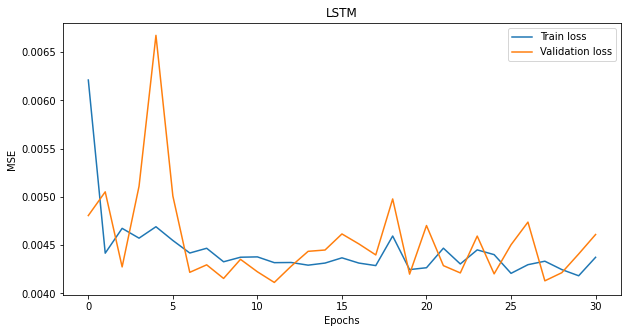

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(10,5))
ax3 = axes
ax3.plot(history.history['loss'], label='Train loss')
ax3.plot(history.history['val_loss'], label='Validation loss')
ax3.legend(loc='best')
ax3.set_title('LSTM')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('MSE')
plt.show()

In [ ]:
col_names_scaled = ['DL_bitrate-0', 	'DL_bitrate-1', 	'DL_bitrate-2', 	'DL_bitrate-3', 	'DL_bitrate-4', 'DL_bitrate']
df = frame_test[col_names_scaled]
df_test_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))

In [ ]:
X_test_scaled = df_test_scaled.iloc[:,:5]

In [ ]:
X_test_scaled.head()

,0,1,2,3,4
0,0.000000,0.000000,0.003680,0.000034,0.000038
1,0.000000,0.000000,0.000000,0.000000,0.003898
2,0.022240,0.000000,0.000000,0.000000,0.000000
3,0.036378,0.048473,0.020858,0.000000,0.000000
4,0.021088,0.032273,0.028277,0.015935,0.031637


In [ ]:
Y_test = frame_test.iloc[:,-1:]
Y_test.reset_index(drop=True,inplace=True)
X_pred_scaled = model.predict(X_test_scaled)
df_test_scaled[5]=X_pred_scaled
#Inverse Transforming the Predicted Values
df_test = pd.DataFrame(min_max_scaler.inverse_transform(df_test_scaled))
Y_pred = df_test.iloc[:,-1:]

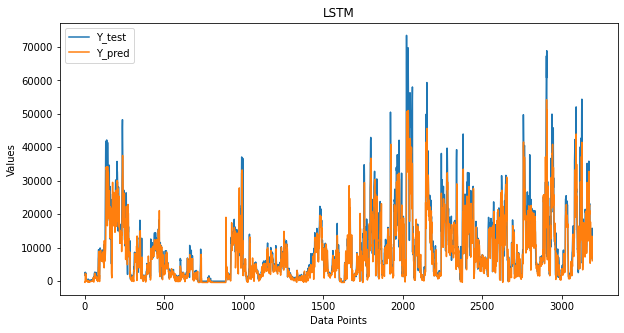

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(10,5))
ax3 = axes
ax3.plot(Y_test, label='Y_test')
ax3.plot(Y_pred, label='Y_pred')
ax3.legend(loc='best')
ax3.set_title('LSTM')
ax3.set_xlabel('Data Points')
ax3.set_ylabel('Values')
plt.show()

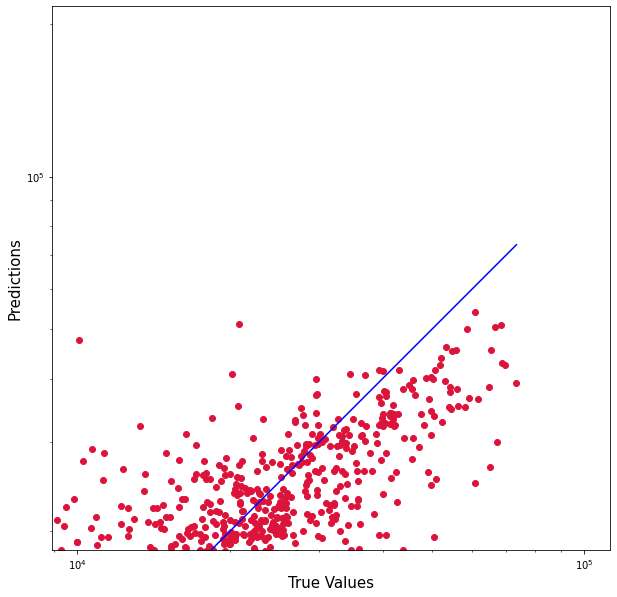

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(Y_test['DL_bitrate'], Y_pred[5], c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(Y_pred[5]), max(Y_test['DL_bitrate']))
p2 = min(min(Y_pred[5]), min(Y_test['DL_bitrate']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

In [ ]:


# calculate MAE
error = mae(Y_test, Y_pred)
  
# display
print("Mean absolute error : " + str(error))

Mean absolute error : 3202.792884942331


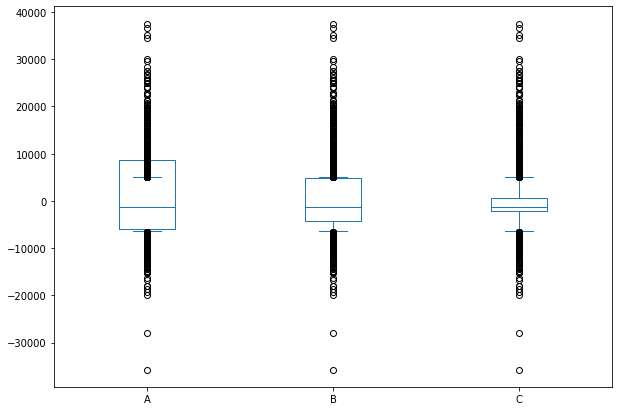

In [ ]:

a=Y_test['DL_bitrate'].subtract(Y_pred[5])
stats = {}
# Compute the boxplot stats (as in the default matplotlib implementation)
stats['A'] = cbook.boxplot_stats(a, labels='A')[0]
stats['B'] = cbook.boxplot_stats(a, labels='B')[0]
stats['C'] = cbook.boxplot_stats(a, labels='C')[0]

# For box A compute the 1st and 99th percentiles
stats['A']['q1'], stats['A']['q3'] = np.percentile(a, [5, 95])
# For box B compute the 10th and 90th percentiles
stats['B']['q1'], stats['B']['q3'] = np.percentile(a, [10, 90])
# For box C compute the 25th and 75th percentiles (matplotlib default)
stats['C']['q1'], stats['C']['q3'] = np.percentile(a, [25, 75])

#fig = plt.figure(figsize =(10, 7))
fig, ax = plt.subplots(1, 1, figsize = (10,7))
# Plot boxplots from our computed statistics
bp = ax.bxp([stats['A'], stats['B'], stats['C']], positions=range(3))

# Colour the lines in the boxplot blue
for element in bp.keys():
    plt.setp(bp[element], color='C0')

# Hyper Parameter Tuning using Keras Auto Tuner

In [ ]:

mae = MeanAbsoluteError()
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(X_train_min_max_series.shape[1], X_train_min_max_series.shape[2])))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512

  hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
  model.add(Dense(units=hp_units1, activation='relu'))
  model.add(Dropout(rate=hp.Float('dropout_1',min_value=0.0,max_value=0.4,default=0.25,step=0.05)))
  model.add(tf.keras.layers.Dense(units=hp_units2, activation='relu'))
  model.add(Dropout(rate=hp.Float('dropout_2',min_value=0.0,max_value=0.4,default=0.25,step=0.05)))
  model.add(tf.keras.layers.Dense(units=hp_units3, activation='relu'))

  model.add(Dropout(rate=hp.Float('dropout_3',min_value=0.0,max_value=0.4,default=0.25,step=0.05)))
  model.add(Dense(1, kernel_initializer='normal', activation='linear'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),loss=mae,metrics=[mae])

  return model


In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_mean_absolute_error',
                     max_epochs=100,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')


In [ ]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=50, 
        verbose=1, mode='auto', restore_best_weights=True)

In [ ]:
tuner.search(X_train_min_max_series, Y_train_min_max_scaler, validation_data=(X_valid_min_max_series, Y_valid_min_max_scaler), epochs=100, callbacks=[monitor])
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 254 Complete [00h 00m 27s]
val_mean_absolute_error: 0.038665737956762314

Best val_mean_absolute_error So Far: 0.037018898874521255
Total elapsed time: 00h 24m 14s


In [ ]:
for h_param in [f"units{i}" for i in range(1,4)] + ['learning_rate']:
  print(h_param, tuner.get_best_hyperparameters()[0].get(h_param))

units1 352
units2 320
units3 384
learning_rate 0.0001


In [ ]:
best_model = tuner.get_best_models()[0]
best_model.build(X_train_min_max_series.shape)
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 5)                 0         
                                                                 
 dense (Dense)               (None, 352)               2112      
                                                                 
 dropout (Dropout)           (None, 352)               0         
                                                                 
 dense_1 (Dense)             (None, 320)               112960    
                                                                 
 dropout_1 (Dropout)         (None, 320)               0         
                                                                 
 dense_2 (Dense)             (None, 384)               123264    
                                                                 
 dropout_2 (Dropout)         (None, 384)               0

In [ ]:
kt_train_pred_min_max_scaled = best_model.predict(X_train_min_max_scaler)
kt_valid_pred_min_max_scaled = best_model.predict(X_valid_min_max_scaler)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train_min_max_scaler, kt_train_pred_min_max_scaled)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid_min_max_scaler, kt_valid_pred_min_max_scaled)))

Train rmse: 0.06147515842480162
Validation rmse: 0.06303806569588032


In [ ]:
col_names_scaled = ['DL_bitrate-0', 	'DL_bitrate-1', 	'DL_bitrate-2', 	'DL_bitrate-3', 	'DL_bitrate-4', 'DL_bitrate']
df = frame_test[col_names_scaled]
df_test_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))

In [ ]:
X_test_scaled = df_test_scaled.iloc[:,:5]

In [ ]:
X_test_scaled.head()

,0,1,2,3,4
0,0.000000,0.000000,0.003680,0.000034,0.000038
1,0.000000,0.000000,0.000000,0.000000,0.003898
2,0.022240,0.000000,0.000000,0.000000,0.000000
3,0.036378,0.048473,0.020858,0.000000,0.000000
4,0.021088,0.032273,0.028277,0.015935,0.031637


In [ ]:
Y_test = frame_test.iloc[:,-1:]
Y_test.reset_index(drop=True,inplace=True)
X_pred_scaled = best_model.predict(X_test_scaled)
df_test_scaled[5]=X_pred_scaled
#Inverse Transforming the Predicted Values
df_test = pd.DataFrame(min_max_scaler.inverse_transform(df_test_scaled))
Y_pred = df_test.iloc[:,-1:]

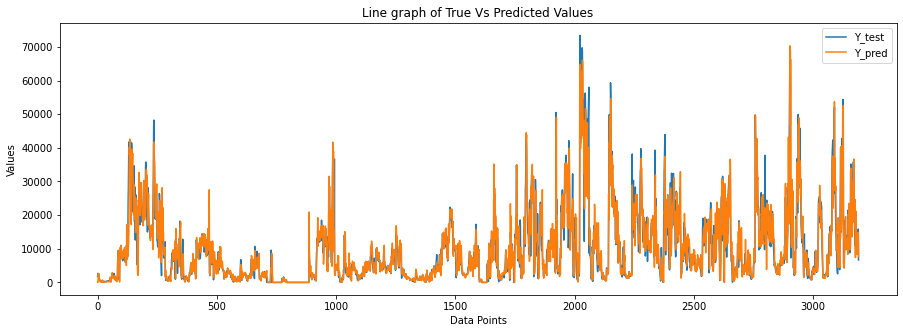

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(15,5))
ax3 = axes
ax3.plot(Y_test, label='Y_test')
ax3.plot(Y_pred, label='Y_pred')
ax3.legend(loc='best')
ax3.set_title('Line graph of True Vs Predicted Values')
ax3.set_xlabel('Data Points')
ax3.set_ylabel('Values')
plt.show()

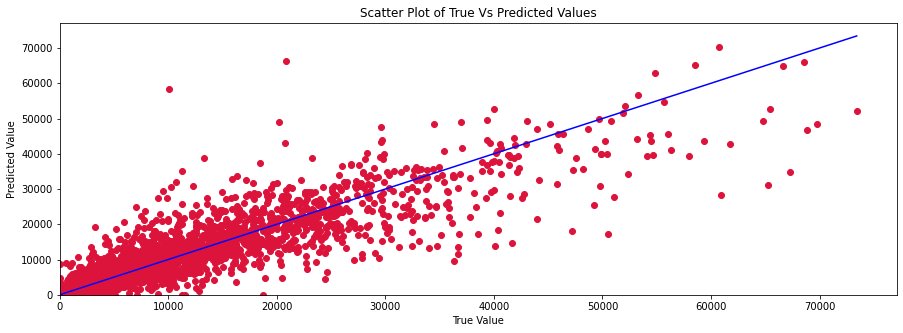

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(15,5))
ax3 = axes
ax3.scatter(Y_test['DL_bitrate'], Y_pred[5], c='crimson')
p1 = max(max(Y_pred[5]), max(Y_test['DL_bitrate']))
p2 = min(min(Y_pred[5]), min(Y_test['DL_bitrate']))
ax3.plot([p1, p2], [p1, p2], 'b-')
ax3.set(xlim=(0, None),ylim=(0, None), title='Scatter Plot of True Vs Predicted Values', xlabel='True Value', ylabel='Predicted Value')
plt.show()

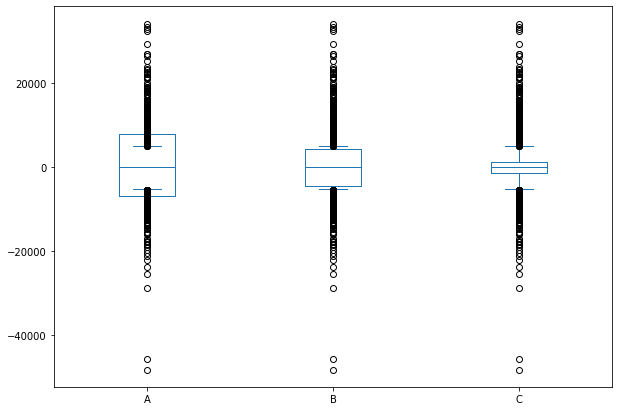

In [ ]:
a=Y_test['DL_bitrate'].subtract(Y_pred[5])
stats = {}
# Compute the boxplot stats (as in the default matplotlib implementation)
stats['A'] = cbook.boxplot_stats(a, labels='A')[0]
stats['B'] = cbook.boxplot_stats(a, labels='B')[0]
stats['C'] = cbook.boxplot_stats(a, labels='C')[0]

# For box A compute the 1st and 99th percentiles
stats['A']['q1'], stats['A']['q3'] = np.percentile(a, [5, 95])
# For box B compute the 10th and 90th percentiles
stats['B']['q1'], stats['B']['q3'] = np.percentile(a, [10, 90])
# For box C compute the 25th and 75th percentiles (matplotlib default)
stats['C']['q1'], stats['C']['q3'] = np.percentile(a, [25, 75])

#fig = plt.figure(figsize =(10, 7))
fig, ax = plt.subplots(1, 1, figsize = (10,7))
# Plot boxplots from our computed statistics
bp = ax.bxp([stats['A'], stats['B'], stats['C']], positions=range(3))

# Colour the lines in the boxplot blue
for element in bp.keys():
    plt.setp(bp[element], color='C0')

In [ ]:

# calculate MAE
error = mae(Y_test, Y_pred)
  
# display
print("Mean absolute error : " + str(error))

Mean absolute error : tf.Tensor(2807.6259765625, shape=(), dtype=float64)


In [ ]:
# Mean Absolute Percentage Error

error = mean_absolute_percentage_error(Y_test, Y_pred)
print(error)

3.920788298547373e+16


In [ ]:
# Relative Absolute Error
# (|y1-y2|)/(|y1_mean-y1|)
def relative_absolute_error(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.absolute(np.array(y1) - np.array(y2)))
  deno = np.sum(np.absolute(y2-np.mean(y1)))
  return (num/deno)

In [ ]:
relative_absolute_error(Y_test, Y_pred)

0.36450742964601757

In [ ]:
# Root Relative Squared Error
# (|y1-y2|^2)/(|y1_mean-y1|^2)
def rrse(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.square(np.absolute(np.array(y1) - np.array(y2))))
  deno = np.sum(np.square(np.absolute(y2-np.mean(y1))))
  return (num/deno)

In [ ]:
rrse(Y_test, Y_pred)

0.23478509628457314

# Combination of Different Modes of Transportaion

In [ ]:
path = r'/content/gdrive/MyDrive/transformed' # use your path
bus_all_files = glob.glob(path + "/bus/*.csv")
car_all_files = glob.glob(path + "/car/*.csv")
pedestrian_all_files = glob.glob(path + "/pedestrian/*.csv")
static_all_files = glob.glob(path + "/static/*.csv")
train_all_files = glob.glob(path + "/train/*.csv")  

In [ ]:
all_files=[]

In [ ]:
bus_all_files.sort()
all_files = all_files + bus_all_files + car_all_files + pedestrian_all_files + static_all_files + train_all_files

In [ ]:
# Train Dataset
li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)
frame = pd.concat(li, axis=0, ignore_index=True)
frame.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
0,7,7,10,7,7,0,0,310,3,3,...,7.0,7.0,10.0,10.0,0,0,14,7,7,1769
1,7,7,7,10,7,0,0,0,310,3,...,8.0,7.0,7.0,10.0,0,0,0,14,7,2272
2,7,7,7,7,10,0,0,0,0,310,...,8.0,8.0,7.0,7.0,0,0,0,0,14,2549
3,9,7,7,7,7,1757,0,0,0,0,...,10.0,8.0,8.0,7.0,68,0,0,0,0,2674
4,9,9,7,7,7,4216,1757,0,0,0,...,10.0,10.0,8.0,8.0,151,68,0,0,0,2393


In [ ]:
frame.shape

(173308, 46)

# Dealing with NaN values

In [ ]:
frame.replace('-', np.NaN, inplace = True)
frame.isna().sum().sum()

1412508

In [ ]:
imputer = IterativeImputer(imputation_order='ascending',max_iter=10,random_state=42,n_nearest_features=None)
imputed_dataset = imputer.fit_transform(frame)
frame = pd.DataFrame(imputed_dataset,columns = frame.columns)
frame.isna().sum().sum()

0

In [ ]:
frame.describe()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
count,173308.000000,173308.000000,173308.000000,173308.000000,173308.000000,173308.000000,173308.000000,173308.000000,173308.000000,173308.000000,...,173308.000000,173308.000000,173308.000000,173308.000000,173308.000000,173308.000000,173308.000000,173308.000000,173308.000000,173308.000000
mean,7.802680,7.762008,7.773866,7.758458,7.766851,10808.171313,10810.279173,10812.429045,10815.209465,10817.850803,...,6.035456,5.847621,5.892696,5.974610,184.515366,184.544349,184.574797,184.610364,184.649508,10801.785665
std,2.553460,2.560483,2.558167,2.562291,2.561450,14141.293894,14144.785379,14147.370251,14151.142228,14155.225829,...,6.788329,6.749466,6.757639,6.782211,220.351485,220.395237,220.422796,220.457359,220.510902,13662.110094
min,-0.633076,1.000000,1.000000,1.000000,0.784749,0.000000,0.000000,0.000000,0.000000,0.000000,...,-30.000000,-30.000000,-30.000000,-30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,7.000000,7.000000,7.000000,7.000000,1386.000000,1386.000000,1386.000000,1386.000000,1386.000000,...,2.000000,2.000000,2.000000,2.000000,32.000000,32.000000,32.000000,32.000000,32.000000,1596.000000
50%,7.329336,7.186727,7.227594,7.177993,7.211425,5368.000000,5368.000000,5368.000000,5368.000000,5368.000000,...,7.434324,6.905200,7.000000,7.000000,107.000000,107.000000,107.000000,107.000000,107.000000,5611.000000
75%,9.000000,9.000000,9.000000,9.000000,9.000000,14774.000000,14774.000000,14785.000000,14785.000000,14785.000000,...,8.000000,7.588702,7.849509,8.000000,266.000000,266.000000,266.000000,266.000000,266.000000,14952.000000
max,15.000000,15.000000,15.000000,15.000000,15.000000,173016.000000,173016.000000,173016.000000,173016.000000,173016.000000,...,33.000000,33.000000,33.000000,33.697735,4178.000000,4178.000000,4178.000000,4178.000000,4178.000000,161878.000000


# Random Split

In [ ]:
frame_train = frame.sample(frac = 0.7, random_state=0)
frame_test = frame.drop(frame_train.index)

In [ ]:
frame_train.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
49904,10.000000,9.000000,9.000000,8.000000,12.000000,47039.0,38774.0,42420.0,53247.0,41772.0,...,11.000000,11.000000,14.000000,14.000000,547.0,413.0,460.0,532.0,369.0,25897.0
10432,11.000000,11.000000,10.000000,11.000000,12.000000,46245.0,48628.0,53884.0,53314.0,53146.0,...,15.000000,14.000000,14.000000,14.000000,913.0,944.0,1065.0,1037.0,1050.0,48703.0
111290,8.000000,8.000000,5.000000,5.000000,9.000000,9025.0,4395.0,5144.0,6095.0,9159.0,...,2.000000,6.000000,6.000000,7.000000,228.0,151.0,234.0,102.0,169.0,3891.0
165744,7.355314,7.169824,7.048104,7.026775,7.117201,324.0,525.0,525.0,570.0,190.0,...,7.285093,6.673948,7.119487,7.265643,7.0,9.0,10.0,10.0,4.0,247.0
48759,5.000000,5.000000,5.000000,5.000000,5.000000,223.0,145.0,402.0,771.0,749.0,...,-8.000000,-8.000000,-6.000000,-6.000000,6.0,3.0,6.0,14.0,17.0,71.0


In [ ]:
frame_test.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
2,7.0,7.0,7.0,7.0,10.0,0.0,0.0,0.0,0.0,310.0,...,8.0,8.0,7.0,7.0,0.0,0.0,0.0,0.0,14.0,2549.0
4,9.0,9.0,7.0,7.0,7.0,4216.0,1757.0,0.0,0.0,0.0,...,10.0,10.0,8.0,8.0,151.0,68.0,0.0,0.0,0.0,2393.0
5,9.0,9.0,9.0,7.0,7.0,2874.0,4216.0,1757.0,0.0,0.0,...,10.0,10.0,10.0,8.0,53.0,151.0,68.0,0.0,0.0,2151.0
10,7.0,9.0,7.0,7.0,8.0,1666.0,2807.0,2382.0,1386.0,2516.0,...,9.0,9.0,12.0,10.0,60.0,52.0,45.0,26.0,47.0,2462.0
21,7.0,9.0,9.0,9.0,9.0,100.0,313.0,1107.0,156.0,2169.0,...,7.0,9.0,9.0,10.0,5.0,12.0,30.0,5.0,69.0,650.0


# MinMax Scaler

In [ ]:
col_names_scaled = ['DL_bitrate-0', 	'DL_bitrate-1', 	'DL_bitrate-2', 	'DL_bitrate-3', 	'DL_bitrate-4', 'DL_bitrate']

In [ ]:
df = frame_train[col_names_scaled]
min_max_scaler = MinMaxScaler()
# transform data
df_min_max_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))

In [ ]:
X_train_min_max_scaler, X_valid_min_max_scaler, Y_train_min_max_scaler, Y_valid_min_max_scaler = train_test_split(df_min_max_scaled.iloc[:,:5], df_min_max_scaled.iloc[:,-1:], test_size=0.3, random_state=0)
print('Train set shape', X_train_min_max_scaler.shape)
print('Validation set shape', X_valid_min_max_scaler.shape)
X_train_min_max_scaler.head()

Train set shape (84921, 5)
Validation set shape (36395, 5)


,0,1,2,3,4
47723,0.079894,0.051579,0.060973,0.082611,0.087004
50990,0.088038,0.089847,0.078942,0.078149,0.097864
24873,0.082738,0.116868,0.120002,0.096638,0.096638
41093,0.031673,0.018097,0.019582,0.044990,0.038008
60737,0.019582,0.016871,0.024763,0.028570,0.026628


In [ ]:
X_train_min_max_series = X_train_min_max_scaler.values.reshape((X_train_min_max_scaler.shape[0], X_train_min_max_scaler.shape[1], 1))
X_valid_min_max_series = X_valid_min_max_scaler.values.reshape((X_valid_min_max_scaler.shape[0], X_valid_min_max_scaler.shape[1], 1))
print('Train set shape', X_train_min_max_series.shape)
print('Validation set shape', X_valid_min_max_series.shape)

Train set shape (84921, 5, 1)
Validation set shape (36395, 5, 1)


In [ ]:
mae = MeanAbsoluteError()
model_high = keras.Sequential()
model_high.add(keras.layers.Flatten(input_shape=(X_train_min_max_series.shape[1], X_train_min_max_series.shape[2])))
model_high.add(Dense(units=352, activation='relu'))
model_high.add(Dropout(rate=0))
model_high.add(tf.keras.layers.Dense(units=320, activation='relu'))
model_high.add(Dropout(rate=0))
model_high.add(tf.keras.layers.Dense(units=384, activation='relu'))
model_high.add(Dropout(rate=0))
model_high.add(Dense(1, kernel_initializer='normal', activation='linear'))
model_high.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=mae,metrics=[mae])
model_high.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 5)                 0         
                                                                 
 dense_4 (Dense)             (None, 352)               2112      
                                                                 
 dropout_3 (Dropout)         (None, 352)               0         
                                                                 
 dense_5 (Dense)             (None, 320)               112960    
                                                                 
 dropout_4 (Dropout)         (None, 320)               0         
                                                                 
 dense_6 (Dense)             (None, 384)               123264    
                                                                 
 dropout_5 (Dropout)         (None, 384)              

In [ ]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=30, 
        verbose=1, mode='auto', restore_best_weights=True)
history=model_high.fit(X_train_min_max_series, Y_train_min_max_scaler, validation_data=(X_valid_min_max_series, Y_valid_min_max_scaler),
        callbacks=[monitor],verbose=1,epochs=500)

Epoch 1/500
2654/2654 [==============================] - 8s 3ms/step - loss: 0.0166 - mean_absolute_error: 0.0166 - val_loss: 0.0165 - val_mean_absolute_error: 0.0165
Epoch 2/500
2654/2654 [==============================] - 7s 3ms/step - loss: 0.0162 - mean_absolute_error: 0.0162 - val_loss: 0.0164 - val_mean_absolute_error: 0.0164
Epoch 3/500
2654/2654 [==============================] - 7s 3ms/step - loss: 0.0162 - mean_absolute_error: 0.0162 - val_loss: 0.0163 - val_mean_absolute_error: 0.0163
Epoch 4/500
2654/2654 [==============================] - 7s 3ms/step - loss: 0.0162 - mean_absolute_error: 0.0162 - val_loss: 0.0163 - val_mean_absolute_error: 0.0163
Epoch 5/500
2654/2654 [==============================] - 7s 3ms/step - loss: 0.0162 - mean_absolute_error: 0.0162 - val_loss: 0.0163 - val_mean_absolute_error: 0.0163
Epoch 6/500
2654/2654 [==============================] - 7s 3ms/step - loss: 0.0162 - mean_absolute_error: 0.0162 - val_loss: 0.0163 - val_mean_absolute_error: 0.016

In [ ]:
kt_train_pred_min_max_scaled = model_high.predict(X_train_min_max_scaler)
kt_valid_pred_min_max_scaled = model_high.predict(X_valid_min_max_scaler)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train_min_max_scaler, kt_train_pred_min_max_scaled)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid_min_max_scaler, kt_valid_pred_min_max_scaled)))

Train rmse: 0.030260952851267002
Validation rmse: 0.030462017103435254


In [ ]:
df = frame_test[col_names_scaled]
df_test_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))
X_test_scaled = df_test_scaled.iloc[:,:-1]
X_test_scaled.head()

,0,1,2,3,4
0,0.000000,0.000000,0.000000,0.000000,0.001866
1,0.027009,0.010835,0.000000,0.000000,0.000000
2,0.018412,0.026000,0.010155,0.000000,0.000000
3,0.010673,0.017310,0.013768,0.008628,0.015141
4,0.000641,0.001930,0.006398,0.000971,0.013053


In [ ]:
Y_test = frame_test['DL_bitrate']
Y_test.reset_index(drop=True,inplace=True)
X_pred_scaled = model_high.predict(X_test_scaled)
df_test_scaled[5]=X_pred_scaled
#Inverse Transforming the Predicted Values
df_test = pd.DataFrame(min_max_scaler.inverse_transform(df_test_scaled))
Y_pred = df_test.iloc[:,-1:]

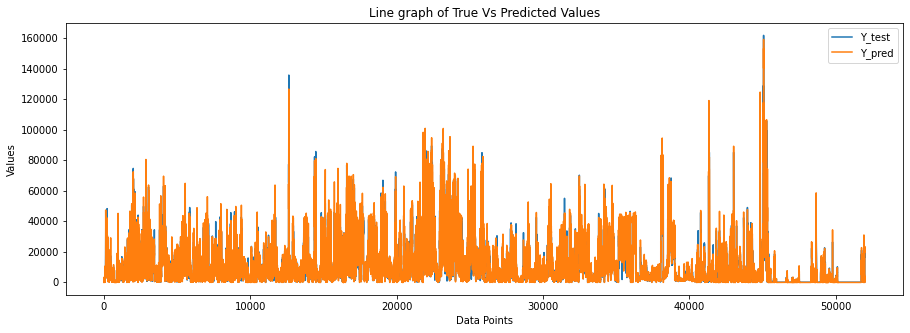

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(15,5))
ax3 = axes
ax3.plot(Y_test, label='Y_test')
ax3.plot(Y_pred, label='Y_pred')
ax3.legend(loc='best')
ax3.set_title('Line graph of True Vs Predicted Values')
ax3.set_xlabel('Data Points')
ax3.set_ylabel('Values')
plt.show()

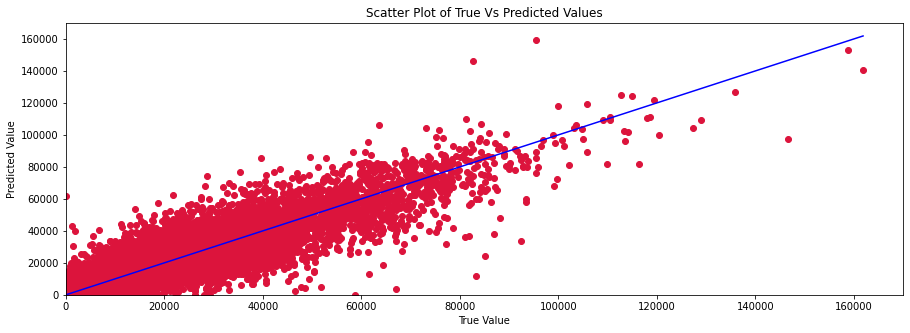

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(15,5))
ax3 = axes
ax3.scatter(Y_test, Y_pred[5], c='crimson')
p1 = max(max(Y_pred[5]), max(Y_test))
p2 = min(min(Y_pred[5]), min(Y_test))
ax3.plot([p1, p2], [p1, p2], 'b-')
ax3.set(xlim=(0, None),ylim=(0, None), title='Scatter Plot of True Vs Predicted Values', xlabel='True Value', ylabel='Predicted Value')
plt.show()

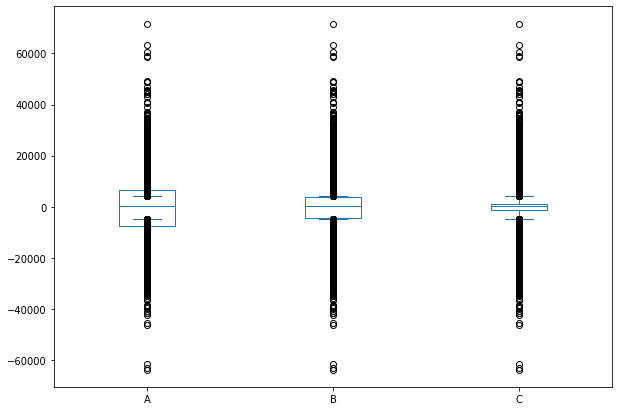

In [ ]:
a=Y_test.subtract(Y_pred[5])
stats = {}
# Compute the boxplot stats (as in the default matplotlib implementation)
stats['A'] = cbook.boxplot_stats(a, labels='A')[0]
stats['B'] = cbook.boxplot_stats(a, labels='B')[0]
stats['C'] = cbook.boxplot_stats(a, labels='C')[0]

# For box A compute the 1st and 99th percentiles
stats['A']['q1'], stats['A']['q3'] = np.percentile(a, [5, 95])
# For box B compute the 10th and 90th percentiles
stats['B']['q1'], stats['B']['q3'] = np.percentile(a, [10, 90])
# For box C compute the 25th and 75th percentiles (matplotlib default)
stats['C']['q1'], stats['C']['q3'] = np.percentile(a, [25, 75])

#fig = plt.figure(figsize =(10, 7))
fig, ax = plt.subplots(1, 1, figsize = (10,7))
# Plot boxplots from our computed statistics
bp = ax.bxp([stats['A'], stats['B'], stats['C']], positions=range(3))

# Colour the lines in the boxplot blue
for element in bp.keys():
    plt.setp(bp[element], color='C0')

In [ ]:
Y_pred_series = Y_pred[5]

In [ ]:
# calculate MAE
error = mae(Y_test, Y_pred_series)
  
# display
print("Mean absolute error : " + str(error))

Mean absolute error : tf.Tensor(2666.79931640625, shape=(), dtype=float64)


In [ ]:
# Relative Absolute Error
# (|y1-y2|)/(|y1_mean-y1|)
def relative_absolute_error(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.absolute(np.array(y1) - np.array(y2)))
  deno = np.sum(np.absolute(y2-np.mean(y1)))
  return (num/deno)

In [ ]:
relative_absolute_error(Y_test, Y_pred_series)

0.26886749378944996

In [ ]:
# Root Relative Squared Error
# (|y1-y2|^2)/(|y1_mean-y1|^2)
def rrse(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.square(np.absolute(np.array(y1) - np.array(y2))))
  deno = np.sum(np.square(np.absolute(y2-np.mean(y1))))
  return (num/deno)

In [ ]:
rrse(Y_test, Y_pred_series)

0.1273114894485586